# Sentinel-1 InSAR coherence from SLC pre-processing

This notebook provides an example to compute the geocoded InSAR coherence on user defined InSAR pairs, using the common pre-processing SLC workflow and performing the coherence computation with native openEO processes.

## Import Libraries

In [19]:
import openeo
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

url = "https://openeo-staging.dataspace.copernicus.eu"
connection = openeo.connect(url).authenticate_oidc()

Authenticated using refresh token.


## SLC pre-processing

Run the openEO process `insar_preprocessing`: given the burst id, the subswath, the temporal range and a master date, it coregisters all the SLC bursts to the same master.

In [ ]:
datacube = connection.datacube_from_process("insar_preprocessing", 
                                 burst_id = 249435, 
                                 sub_swath = "IW2",
                                 temporal_extent = ["2024-08-09", "2024-09-02"],
                                 master_date = "2024-09-02",
                                 polarization = "vv"
                                ).save_result("GTiff")


job = datacube.create_job(title="cloudinsar_slc_preprocessing_vv",job_options={"python-memory": "4000m"})
job.start_job()

Once that the openEO batch job is completed, we can proceed

In [3]:
job_id = "j-251002125814457c89eba8136a862085"
job = connection.job(job_id)
job

<BatchJob job_id='j-251002125814457c89eba8136a862085'>

## Coherence estimation

Set required parameters for the coherence workflow:
- temporal baseline
- window size
- crs and resolution for the geocoding

In [4]:
# Temporal baseline
timedelta = 12 # Days

# Boxcar filter
range_dim   = 21
azimuth_dim = 5

# Geocoding
resolution = 20
crs = "EPSG:32632"

Read the list of available dates in the pre-processed Sentinel-1 SLC data:

In [5]:
def get_stac_from_job_id(job_id):
    job = connection.job(job_id)
    stac_result = job.get_results().get_metadata()
    stac_result_url = [x["href"] for x in stac_result["links"] if x["rel"]=="canonical"][0]
    return stac_result_url

stac_url = get_stac_from_job_id(job_id)
print(f"STAC URL of the openEO job is: {stac_url}")

def get_dates_from_openeo_stac(stac_url):
    import pystac
    dates = []
    for f in pystac.read_file(stac_url).get_assets():
        dates.append(np.datetime64(f.split("_")[1].split(".tif")[0][:-1]))
    return dates

pre_processed_dates =  get_dates_from_openeo_stac(stac_url)
print(f"The pre-processed dates are: {pre_processed_dates}")

STAC URL of the openEO job is: https://openeo-staging.dataspace.copernicus.eu/openeo/1.2/jobs/j-251002125814457c89eba8136a862085/results/MGVkMGZhNTEtMGNmMC00YzI1LWE5NWYtNGY3MDA0NGVjYWYy/697dbe486b4439a34a60a0f01f0f2749?expires=1760346186
The pre-processed dates are: [numpy.datetime64('2024-08-09'), numpy.datetime64('2024-08-21'), numpy.datetime64('2024-09-02')]


Compute the primary-secondary pairs for the given temporal baseline.

In [6]:
dates_pair = []
for i,t in enumerate(pre_processed_dates[:-1]):
    for t2 in pre_processed_dates[i+1:]:
        if(np.timedelta64(t2 - t, "D")) == np.timedelta64(timedelta,"D"):
            dates_pair.append([t,t2])
print("First date pair: ",dates_pair[0])
print("Last date pair:  ",dates_pair[-1])

First date pair:  [numpy.datetime64('2024-08-09'), numpy.datetime64('2024-08-21')]
Last date pair:   [numpy.datetime64('2024-08-21'), numpy.datetime64('2024-09-02')]


Re use the pre-processed Sentinel-1 SLC data via STAC:

In [7]:
cube = connection.load_stac_from_job(job_id)
cube

Check the metadata of the loaded datacube:

In [8]:
cube.metadata.band_names

['i_VV', 'q_VV', 'grid_lat', 'grid_lon']

The next functions are the representation of the complex coherence formula using separate real and imaginary parts:

In [9]:
from openeo.processes import ProcessBuilder, array_element, array_create

def compute_parts_VV(x:ProcessBuilder):
    i_prm = array_element(x,label="i_VV_prm")
    q_prm = array_element(x,label="q_VV_prm")
    i_sec = array_element(x,label="i_VV_sec")
    q_sec = array_element(x,label="q_VV_sec")
    return array_create([i_prm*i_sec + q_prm*q_sec,q_prm*i_sec - i_prm*q_sec,i_prm**2+q_prm**2,i_sec**2+q_sec**2])
    
def compute_parts_VH(x:ProcessBuilder):
    i_prm = array_element(x,label="i_VH_prm")
    q_prm = array_element(x,label="q_VH_prm")
    i_sec = array_element(x,label="i_VH_sec")
    q_sec = array_element(x,label="q_VH_sec")
    return array_create([i_prm*i_sec + q_prm*q_sec,q_prm*i_sec - i_prm*q_sec,i_prm**2+q_prm**2,i_sec**2+q_sec**2])
    
def compute_coherence_amplitude_VV(x:ProcessBuilder):
    q_num_VV = array_element(x,label="q_num_VV")
    i_num_VV = array_element(x,label="i_num_VV")
    prm_den = array_element(x,label="prm_den")
    sec_den = array_element(x,label="sec_den")
    
    coh_i = i_num_VV / ((prm_den * sec_den + 1e-12)**0.5)
    coh_q = q_num_VV / ((prm_den * sec_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

def compute_coherence_amplitude_VH(x:ProcessBuilder):
    q_num_VH = array_element(x,label="q_num_VH")
    i_num_VH = array_element(x,label="i_num_VH")
    prm_den = array_element(x,label="prm_den")
    sec_den = array_element(x,label="sec_den")
    
    coh_i = i_num_VH / ((prm_den * sec_den + 1e-12)**0.5)
    coh_q = q_num_VH / ((prm_den * sec_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

We use a loop over the dates we want to request and a combination of `filter_temporal` + `merge_cubes` to get only the dates we want:

In [10]:
for i,date_pair in enumerate(dates_pair):
    # The requested date until the day after, since openEO excludes the end date
    prm_date = date_pair[0]
    sec_date = date_pair[1]
    prm_temporal_extent = [str(prm_date),str(prm_date + np.timedelta64(1, "D"))]
    sec_temporal_extent = [str(sec_date),str(sec_date + np.timedelta64(1, "D"))]

    if i == 0:
        S1_slant_range_prm_bands = cube.filter_temporal(prm_temporal_extent)
        S1_slant_range_sec_bands = cube.filter_temporal(sec_temporal_extent)
        break # +++++++++++++++++++++ Do it only for one pair for testing
    else:
        S1_slant_range_prm_bands = cube.filter_temporal(prm_temporal_extent).merge_cubes(S1_slant_range_prm_bands)
        S1_slant_range_sec_bands = cube.filter_temporal(sec_temporal_extent).merge_cubes(S1_slant_range_sec_bands)
        
S1_slant_range_prm_bands = S1_slant_range_prm_bands.filter_bands(["i_VV","q_VV"]).drop_dimension("t") # "i_" real part,"q_" imaginary part
S1_slant_range_sec_bands = S1_slant_range_sec_bands.filter_bands(["i_VV","q_VV"]).drop_dimension("t")

S1_slant_range_prm_bands = S1_slant_range_prm_bands.rename_labels(dimension="bands",
                                                                  source=["i_VV","q_VV"],
                                                                  target=["i_VV_prm","q_VV_prm"])
S1_slant_range_sec_bands = S1_slant_range_sec_bands.rename_labels(dimension="bands",
                                                                  source=["i_VV","q_VV"],
                                                                  target=["i_VV_sec","q_VV_sec"])

S1_slant_range_prm_sec_bands = S1_slant_range_prm_bands.merge_cubes(S1_slant_range_sec_bands)

Once that we have the primary and secondary real and imaginary parts in separate datacubes, we can start with the coherence estimation.

In [11]:
coh_numerator_denominator_VV = S1_slant_range_prm_sec_bands.apply_dimension(dimension="bands",
                                                               process=compute_parts_VV).rename_labels("bands",target=["i_num_VV","q_num_VV","prm_den","sec_den"])

Create kernel for boxcar filter (sliding window):

In [12]:
# Create kernel
kernel = np.ones((azimuth_dim,range_dim))

# Pad with zeros to get a square kernel
pad = int((range_dim - azimuth_dim) / 2)
kernel = np.pad(kernel,((pad,pad),(0,0)))

Apply the boxcar filter to the numerator and denominator of the coherence formula:

In [13]:
coh_numerator_denominator_VV_boxcar = coh_numerator_denominator_VV.apply_kernel(kernel=kernel,
                                                                                factor=1/(range_dim*azimuth_dim),
                                                                                border=0)

Compute the coherence

In [14]:
coh_VV = coh_numerator_denominator_VV_boxcar.reduce_dimension(dimension="bands",
                                                              reducer=compute_coherence_amplitude_VV)\
                                            .add_dimension(name="bands",type="bands",label="coh_VV")

Prepare the longitude and latitude layers and geocode the coherence:

In [15]:
coordinate_bands = cube.filter_temporal(prm_temporal_extent).filter_bands(["grid_lat","grid_lon"])\
    .drop_dimension("t").rename_labels(dimension="bands", target=["latitude","longitude"])

coh_amplitude = coh_VV.merge_cubes(coordinate_bands)\
    .add_dimension(name="t", type="temporal", label=f"{prm_date}T00:00:00Z")

coh_amplitude = coh_amplitude.resample_spatial(projection=crs,resolution=resolution,method="geocode").save_result(format="GTiff")

Crea a batch job and start it:

In [16]:
job_options = {
    "image-name": "registry.stag.waw3-1.openeo-int.v1.dataspace.copernicus.eu/dev/openeo-geotrellis-kube-python311:20250903-133",
    "openeo-jar-path": "https://artifactory.vgt.vito.be/artifactory/libs-release-public/org/openeo/geotrellis-extensions/geocode/geotrellis-extensions-geocode.jar"
}
job = coh_amplitude.create_job(title="cloudinsar_coherence_from_preprocessing_21x5_10m", job_options=job_options)
job.start_job()

<BatchJob job_id='j-25100609031148f5a043d1df1fc41f61'>

In [17]:
job = connection.job("j-2510031342584a2384a66cfc97ad6763")
job.get_results().download_files("cloudinsar_coherence_from_preprocessing_21x5_20m")

[PosixPath('cloudinsar_coherence_from_preprocessing_21x5_20m/openEO_2024-08-09Z.tif'),
 PosixPath('cloudinsar_coherence_from_preprocessing_21x5_20m/job-results.json')]

## Visualization of the results

We can visualize the result here in Python:

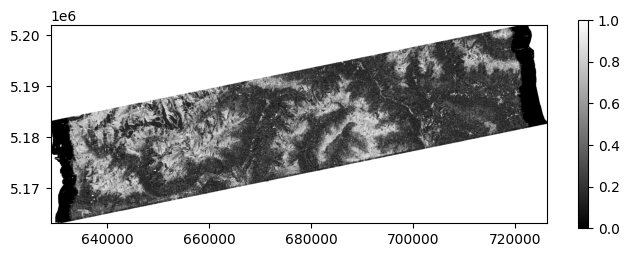

In [32]:
import rioxarray

ds = rioxarray.open_rasterio('cloudinsar_coherence_from_preprocessing_21x5_20m/openEO_2024-08-09Z.tif')[0]
ds = ds.where(~np.isnan(ds),drop=True).fillna(1)
fig, ax = plt.subplots(figsize=(8, 6))
im = show(ds.values, transform=ds.rio.transform(), cmap='gray', ax=ax)
cbar = fig.colorbar(im.get_images()[0], ax=ax, orientation="vertical", shrink=0.45)


Or also in the openEO Web Editor using a custom link:

https://editor.openeo.org/?server=https%3A%2F%2Fopeneo-staging.dataspace.copernicus.eu%2Fopeneo%2F1.2&result=https%3A%2F%2Fopeneo-staging.dataspace.copernicus.eu%2Fopeneo%2F1.2%2Fjobs%2Fj-25100609031148f5a043d1df1fc41f61%2Fresults%2FMGVkMGZhNTEtMGNmMC00YzI1LWE5NWYtNGY3MDA0NGVjYWYy%2Fc76dc630835583dd105a3a1cbe72a170%3Fexpires%3D1760346850
